# Lab 6

You are tasked with evaluating card counting strategies for black jack. In order to do so, you will use object oriented programming to create a playable casino style black jack game where a computer dealer plays against $n$ computer players and possibily one human player. If you don't know the rules of blackjack or card counting, please google it.

A few requirements:
* The game should utilize multiple 52-card decks. Typically the game is played with 6 decks.
* Players should have chips.
* Dealer's actions are predefined by rules of the game (typically hit on 16).
* The players should be aware of all shown cards so that they can count cards.
* Each player could have a different strategy.
* The system should allow you to play large numbers of games, study the outcomes, and compare average winnings per hand rate for different strategies.

1. Begin by creating a classes to represent cards and decks. The deck should support more than one 52-card set. The deck should allow you to shuffle and draw cards. Include a "plastic" card, placed randomly in the deck. Later, when the plastic card is dealt, shuffle the cards before the next deal.

In [44]:
import random

class Card:
    def __init__(self, suit, rank):
        self.suit = suit
        self.rank = rank

    def __repr__(self):
        return f"{self.rank} of {self.suit}"


class Deck:
    def __init__(self, num_decks=6):
        self.num_decks = num_decks
        self.cards = []
        self.plastic_card_index = None
        self.build_deck()
        self.shuffle()

    def build_deck(self):
        suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
        ranks = ['2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K', 'A']
        self.cards = [Card(suit, rank) for suit in suits for rank in ranks] * self.num_decks

        self.plastic_card_index = random.randint(len(self.cards)//4, 3*len(self.cards)//4)

    def shuffle(self):
        random.shuffle(self.cards)

    def draw_card(self):
        if len(self.cards) == 0:
            self.build_deck()
            self.shuffle()
        card = self.cards.pop(0)
        if len(self.cards) <= self.plastic_card_index:
            print("Plastic card reached! Reshuffling next round.")
            self.build_deck()
            self.shuffle()
        return card


2. Now design your game on a UML diagram. You may want to create classes to represent, players, a hand, and/or the game. As you work through the lab, update your UML diagram. At the end of the lab, submit your diagram (as pdf file) along with your notebook.

3. Begin with implementing the skeleton (ie define data members and methods/functions, but do not code the logic) of the classes in your UML diagram.

In [45]:

class Player:
    def __init__(self, name, chips=1000):
        self.name = name
        self.chips = chips
        self.hand = []
        self.bet = 0

    def reset_hand(self):
        self.hand = []
        self.bet = 0

    def receive_card(self, card):
        self.hand.append(card)

    def get_hand_value(self):
        value = 0
        aces = 0
        for card in self.hand:
            if card.rank in ['J', 'Q', 'K']:
                value += 10
            elif card.rank == 'A':
                value += 11
                aces += 1
            else:
                value += int(card.rank)

        while value > 21 and aces:
            value -= 10
            aces -= 1
        return value

    def is_busted(self):
        return self.get_hand_value() > 21



    def place_bet(self, amount=10):
        self.bet = min(amount, self.chips)
        self.chips -= self.bet


class DealerPlayer(Player):
    def place_bet(self):
        super().place_bet(10)

    def play(self, deck):
        while self.get_hand_value() < 17:
            self.receive_card(deck.draw_card())



class CardCountingPlayer(Player):
    def __init__(self, name, chips=1000, threshold=1):
        super().__init__(name, chips)
        self.running_count = 0
        self.threshold = threshold
        self.hands = [self]

    def update_count(self, card):
        """Original count update logic (used in early instructions)"""
        if card.rank in ['2', '3', '4', '5', '6']:
            self.running_count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.running_count -= 1

    def see_card(self, card):

        self.update_count(card)

    def place_bet(self):
        if self.running_count >= self.threshold:
            super().place_bet(100)
        else:
            super().place_bet(10)

    def play(self, deck):
        while self.get_hand_value() < 16:
            card = deck.draw_card()
            self.receive_card(card)
            self.update_count(card)

    def make_decision(self, dealer_up_card):

        decisions = []
        for hand in self.hands:
            if hand.is_busted():
                decisions.append("stay")
                continue

            hand_value = hand.get_hand_value()

            if hand_value <= 11:
                decisions.append("hit")
            elif hand_value >= 17:
                decisions.append("stay")
            else:
                if self.running_count <= self.threshold:
                    decisions.append("hit")
                else:
                    decisions.append("stay")

        return decisions



4. Complete the implementation by coding the logic of all functions. For now, just implement the dealer player and human player.

In [46]:
class Game:
    def __init__(self, players, dealer, num_decks=6):
        self.players = players
        self.dealer = dealer
        self.deck = Deck(num_decks)
        self.all_players = players + [dealer]

    def play_round(self):

        for player in self.all_players:
            player.reset_hand()


        for player in self.players:
            player.place_bet()


        for _ in range(2):
            for player in self.all_players:
                card = self.deck.draw_card()
                player.receive_card(card)
                if isinstance(player, CardCountingPlayer):
                  player.see_card(card)


        for player in self.players:
            if isinstance(player, CardCountingPlayer):
                player.play(self.deck)
            else:
                while player.get_hand_value() < 16:
                    player.receive_card(self.deck.draw_card())


        self.dealer.play(self.deck)


        dealer_value = self.dealer.get_hand_value()
        dealer_busted = self.dealer.is_busted()

        for player in self.players:
            player_value = player.get_hand_value()
            if player.is_busted():
                # Player loses
                continue
            elif dealer_busted or player_value > dealer_value:
                # Player wins
                player.chips += 2 * player.bet
            elif player_value == dealer_value:
                # Push
                player.chips += player.bet
            # else: Dealer wins, chips already deducted

    def get_chip_counts(self):
        return {player.name: player.chips for player in self.players}


5.  Test. Demonstrate game play. For example, create a game of several dealer players and show that the game is functional through several rounds.

In [47]:
def simulate_games(num_rounds=1000, threshold=1):

    counter = CardCountingPlayer("Counter", chips=1000, threshold=threshold)
    follower1 = DealerPlayer("Player 1", chips=1000)
    follower2 = DealerPlayer("Player 2", chips=1000)
    follower3 = DealerPlayer("Player 3", chips=1000)
    dealer = DealerPlayer("Dealer")


    game = Game(players=[counter, follower1, follower2, follower3], dealer=dealer)


    for i in range(num_rounds):
        game.play_round()

    print(f"\nResults after {num_rounds} rounds:")
    for player in [counter, follower1, follower2, follower3]:
        print(f"{player.name}: {player.chips} chips")



simulate_games(num_rounds=500, threshold=2)


Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

6. Implement a new player with the following strategy:

    * Assign each card a value:
        * Cards 2 to 6 are +1
        * Cards 7 to 9 are 0
        * Cards 10 through Ace are -1
    * Compute the sum of the values for all cards seen so far.
    * Hit if sum is very negative, stay if sum is very positive. Select a threshold for hit/stay, e.g. 0 or -2.  

In [48]:
def compare_card_counting_thresholds(thresholds, num_rounds=500):

    results = {}

    for t in thresholds:

        counter = CardCountingPlayer("Counter", chips=1000, threshold=t)


        followers = [DealerPlayer(f"Player {i+1}", chips=1000) for i in range(3)]


        dealer = DealerPlayer("Dealer")


        game = Game(players=[counter] + followers, dealer=dealer)


        for _ in range(num_rounds):
            game.play_round()


        results[t] = counter.chips

    return results


Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

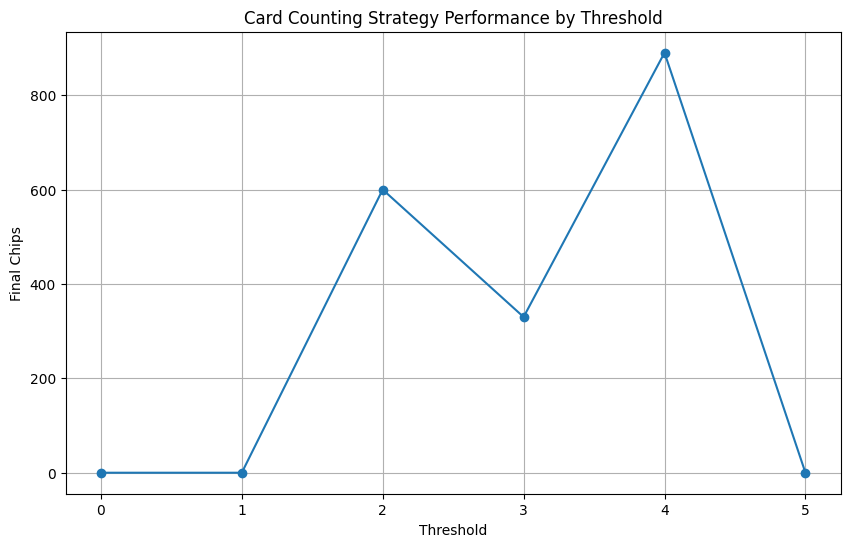

{0: 0, 1: 0, 2: 600, 3: 330, 4: 890, 5: 0}

In [49]:

import matplotlib.pyplot as plt
thresholds_to_test = [0, 1, 2, 3, 4, 5]


threshold_results = compare_card_counting_thresholds(thresholds_to_test)


plt.figure(figsize=(10, 6))
plt.plot(threshold_results.keys(), threshold_results.values(), marker='o')
plt.title("Card Counting Strategy Performance by Threshold")
plt.xlabel("Threshold")
plt.ylabel("Final Chips")
plt.grid(True)
plt.show()


threshold_results


7. Create a test scenario where one player, using the above strategy, is playing with a dealer and 3 other players that follow the dealer's strategy. Each player starts with same number of chips. Play 50 rounds (or until the strategy player is out of money). Compute the strategy player's winnings. You may remove unnecessary printouts from your code (perhaps implement a verbose/quiet mode) to reduce the output.

In [50]:
class CardCountingPlayer(Player):
    def __init__(self, name, chips=1000, threshold=1):
        super().__init__(name, chips)
        self.running_count = 0
        self.threshold = threshold


    def update_count(self, card):
        if card.rank in ['2', '3', '4', '5', '6']:
            self.running_count += 1
        elif card.rank in ['10', 'J', 'Q', 'K', 'A']:
            self.running_count -= 1

    def see_card(self, card):
        self.update_count(card)


    def place_bet(self):
        if self.running_count >= self.threshold:
            super().place_bet(100)  # Bet big
        else:
            super().place_bet(10)   # Bet small


    def play(self, deck):
        while self.get_hand_value() < 16:
            card = deck.draw_card()
            self.receive_card(card)
            self.update_count(card)




In [51]:
def simulate_decision_strategies(thresholds, num_rounds=500):

    results = {}

    for t in thresholds:
        counter = CardCountingPlayer("Counter", chips=1000, threshold=t)
        players = [counter] + [DealerPlayer(f"Player {i+1}", chips=1000) for i in range(3)]
        dealer = DealerPlayer("Dealer")
        game = Game(players=players, dealer=dealer)

        for _ in range(num_rounds):
            game.play_round()

        results[t] = counter.chips

    return results


Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

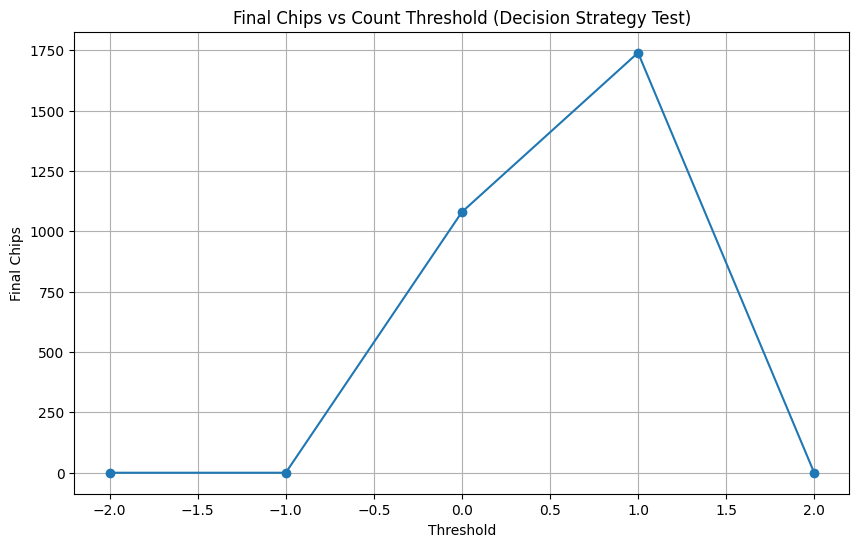

In [52]:
thresholds = [-2, -1, 0, 1, 2]
results = simulate_decision_strategies(thresholds)


plt.figure(figsize=(10, 6))
plt.plot(results.keys(), results.values(), marker='o')
plt.title("Final Chips vs Count Threshold (Decision Strategy Test)")
plt.xlabel("Threshold")
plt.ylabel("Final Chips")
plt.grid(True)
plt.show()


8. Create a loop that runs 100 games of 50 rounds, as setup in previous question, and store the strategy player's chips at the end of the game (aka "winnings") in a list. Histogram the winnings. What is the average winnings per round? What is the standard deviation. What is the probabilty of net winning or lossing after 50 rounds?


In [53]:
class CautiousPlayer(Player):
    def place_bet(self):
        super().place_bet(5)

    def play(self, deck):
        while self.get_hand_value() < 15:
            self.receive_card(deck.draw_card())


def simulate_with_cautious(num_rounds=500, threshold=2):
    cautious = CautiousPlayer("Cautious", chips=1000)
    counter = CardCountingPlayer("Counter", chips=1000, threshold=threshold)
    follower = DealerPlayer("Follower", chips=1000)
    dealer = DealerPlayer("Dealer")

    game = Game(players=[cautious, counter, follower], dealer=dealer)

    for _ in range(num_rounds):
        game.play_round()

    return {
        "Cautious": cautious.chips,
        "Counter": counter.chips,
        "Follower": follower.chips
    }


simulate_with_cautious(num_rounds=500, threshold=2)

Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

{'Cautious': 705, 'Counter': 0, 'Follower': 570}

Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

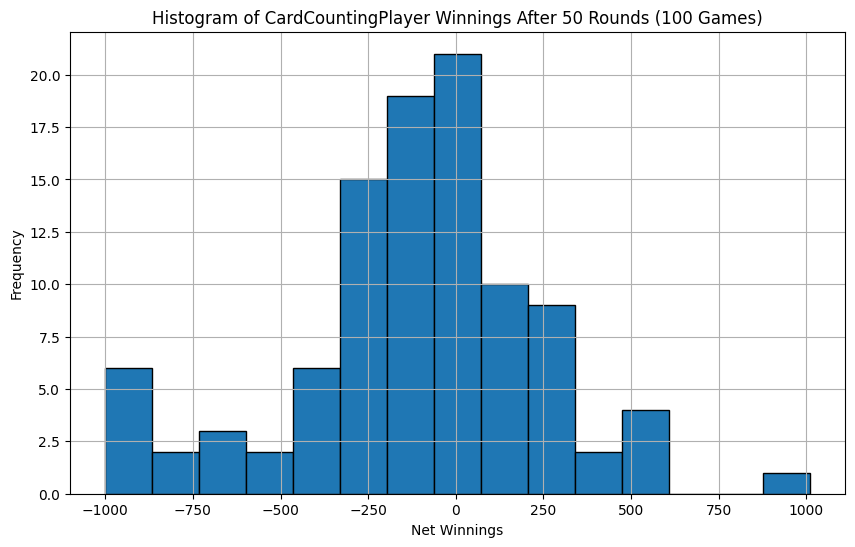

Average Winnings per 50 Rounds: -111.80
Standard Deviation: 365.66
Probability of Net Winning: 36.00%
Probability of Net Losing: 62.00%


In [54]:
import numpy as np
import matplotlib.pyplot as plt


winnings = []

for _ in range(100):
    counter = CardCountingPlayer("Counter", chips=1000, threshold=2)
    follower1 = DealerPlayer("Player 1", chips=1000)
    follower2 = DealerPlayer("Player 2", chips=1000)
    follower3 = DealerPlayer("Player 3", chips=1000)
    dealer = DealerPlayer("Dealer")

    game = Game(players=[counter, follower1, follower2, follower3], dealer=dealer)

    for _ in range(50):
        game.play_round()

    winnings.append(counter.chips - 1000)


winnings_array = np.array(winnings)

plt.figure(figsize=(10, 6))
plt.hist(winnings_array, bins=15, edgecolor='black')
plt.title("Histogram of CardCountingPlayer Winnings After 50 Rounds (100 Games)")
plt.xlabel("Net Winnings")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


mean_winnings = np.mean(winnings_array)
std_dev = np.std(winnings_array)
prob_winning = np.sum(winnings_array > 0) / len(winnings_array)
prob_losing = np.sum(winnings_array < 0) / len(winnings_array)

print(f"Average Winnings per 50 Rounds: {mean_winnings:.2f}")
print(f"Standard Deviation: {std_dev:.2f}")
print(f"Probability of Net Winning: {prob_winning:.2%}")
print(f"Probability of Net Losing: {prob_losing:.2%}")


9. Repeat previous questions scanning the value of the threshold. Try at least 5 different threshold values. Can you find an optimal value?

Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 

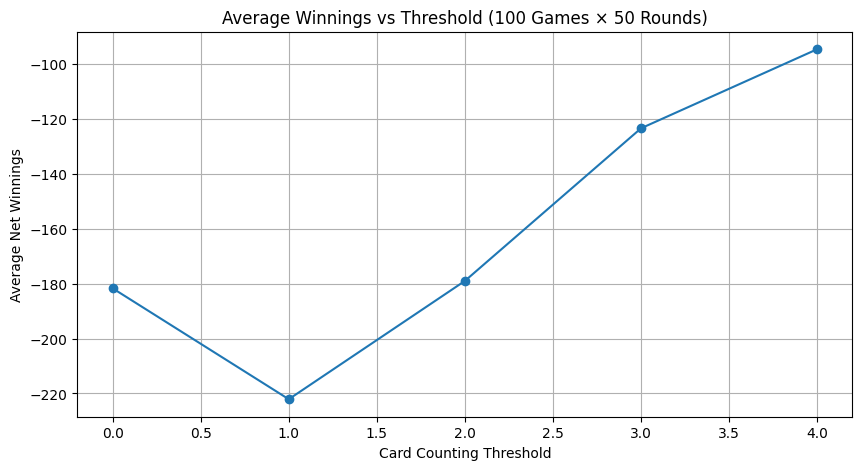

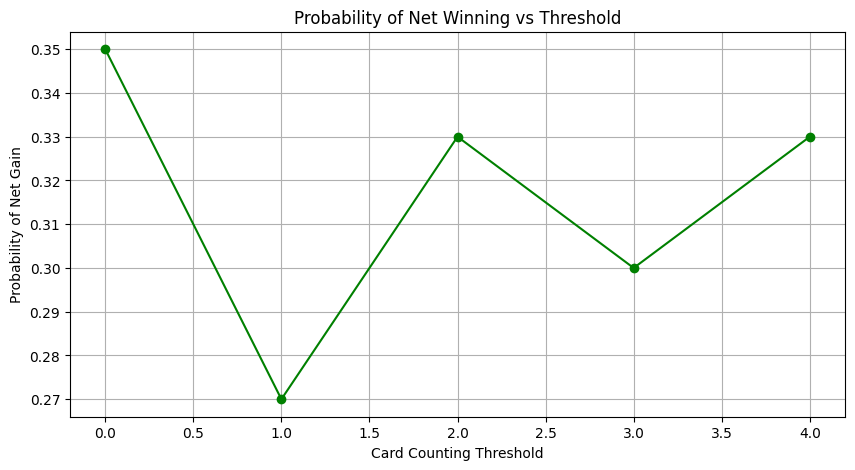

Threshold 0: Mean = -181.70, Std Dev = 452.02, Win Prob = 35.00%
Threshold 1: Mean = -222.10, Std Dev = 429.13, Win Prob = 27.00%
Threshold 2: Mean = -179.00, Std Dev = 407.76, Win Prob = 33.00%
Threshold 3: Mean = -123.40, Std Dev = 367.49, Win Prob = 30.00%
Threshold 4: Mean = -94.60, Std Dev = 336.36, Win Prob = 33.00%


In [55]:
thresholds = [0, 1, 2, 3, 4]

mean_winnings_list = []
std_devs = []
win_probs = []

for t in thresholds:
    threshold_winnings = []

    for _ in range(100):
        counter = CardCountingPlayer("Counter", chips=1000, threshold=t)
        follower1 = DealerPlayer("Player 1", chips=1000)
        follower2 = DealerPlayer("Player 2", chips=1000)
        follower3 = DealerPlayer("Player 3", chips=1000)
        dealer = DealerPlayer("Dealer")

        game = Game(players=[counter, follower1, follower2, follower3], dealer=dealer)

        for _ in range(50):
            game.play_round()

        threshold_winnings.append(counter.chips - 1000)


    winnings_array = np.array(threshold_winnings)
    mean_winnings_list.append(np.mean(winnings_array))
    std_devs.append(np.std(winnings_array))
    win_probs.append(np.sum(winnings_array > 0) / len(winnings_array))


plt.figure(figsize=(10, 5))
plt.plot(thresholds, mean_winnings_list, marker='o')
plt.title("Average Winnings vs Threshold (100 Games × 50 Rounds)")
plt.xlabel("Card Counting Threshold")
plt.ylabel("Average Net Winnings")
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(thresholds, win_probs, marker='o', color='green')
plt.title("Probability of Net Winning vs Threshold")
plt.xlabel("Card Counting Threshold")
plt.ylabel("Probability of Net Gain")
plt.grid(True)
plt.show()


for i, t in enumerate(thresholds):
    print(f"Threshold {t}: Mean = {mean_winnings_list[i]:.2f}, Std Dev = {std_devs[i]:.2f}, Win Prob = {win_probs[i]*100:.2f}%")


10. Create a new strategy based on web searches or your own ideas. Demonstrate that the new strategy will result in increased or decreased winnings.

In [56]:
class StreakReactivePlayer(Player):
    def __init__(self, name, chips=1000):
        super().__init__(name, chips)
        self.streak = []  # Store last 3 results: "win" or "loss"

    def update_streak(self, outcome):
        self.streak.append(outcome)
        if len(self.streak) > 3:
            self.streak.pop(0)

    def place_bet(self):
        # Hot streak (3 wins) → aggressive
        if self.streak == ["win", "win", "win"]:
            super().place_bet(100)
        # Cold streak (3 losses) → cautious
        elif self.streak == ["loss", "loss", "loss"]:
            super().place_bet(5)
        else:
            super().place_bet(10)

    def play(self, deck):
        value = self.get_hand_value()
        if self.streak == ["win", "win", "win"]:
            while value < 18:
                self.receive_card(deck.draw_card())
                value = self.get_hand_value()
        elif self.streak == ["loss", "loss", "loss"]:
            while value < 14:
                self.receive_card(deck.draw_card())
                value = self.get_hand_value()
        else:
            while value < 16:
                self.receive_card(deck.draw_card())
                value = self.get_hand_value()


In [58]:
def simulate_streak_strategy(num_rounds=500):
    streaker = StreakReactivePlayer("Streaker", chips=1000)
    opponents = [DealerPlayer(f"Player {i+1}", chips=1000) for i in range(3)]
    dealer = DealerPlayer("Dealer")
    game = Game(players=[streaker] + opponents, dealer=dealer)

    for _ in range(num_rounds):
        before = streaker.chips
        game.play_round()
        after = streaker.chips

        if after > before:
            streaker.update_streak("win")
        elif after < before:
            streaker.update_streak("loss")

    return streaker.chips


In [59]:
final_chips = simulate_streak_strategy(500)
print(f"Final chips for StreakReactivePlayer after 500 rounds: {final_chips}")
print(f"Net Winnings: {final_chips - 1000}")


Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling next round.
Plastic card reached! Reshuffling 